# Plotting heuristics of Machine Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* June2022: Adding multiple plots  
* Aug2022: Ploting multiple trians

## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 




# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import fnmatch
import sys
import argparse
import yaml
from pathlib import Path
import json    

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

import numpy as np
import pandas as pd
import seaborn as sns

from typing import Dict, List, Tuple

from source.helpers.learning_pipeline import json2DataFrame, \
                                            jsonPARAMS2DataFrame


HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH

#### Setting RESULTS_PATH and TRAINING_CURVES_PATH
# RESULTS_PATH='scripts/learning-pipeline/results/1st-tests-23-june-2022'
#RESULTS_PATH='scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-01-02-03-04'
#RESULTS_PATH='scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-04-05-06-07'
#RESULTS_PATH='scripts/learning-pipeline/results/3rd-tests-30-june-2022/experiments-09-10-11-12'
# RESULTS_PATH='scripts/learning-pipeline/results/5th-tests-04-augs-2022/05-subjects'
RESULTS_PATH='scripts/learning-pipeline/results/5th-tests-04-augs-2022/31-subjects'


TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)
## Printing Versions and paths
print(f'Pandas Version: {pd.__version__}')
print(f'seaborn Version: {sns.__version__}')
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )

Pandas Version: 1.4.2
seaborn Version: 0.11.1
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/5th-tests-04-augs-2022/31-subjects


## 2. Reading dictionaries and filtering files

In [2]:
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )
os.chdir(TRAINING_CURVES_PATH)

pattern = 'TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC*.json'
json_files=fnmatch.filter(  sorted(os.listdir(TRAINING_CURVES_PATH))  , pattern)
print(f'-------------------')
print(f'-----Stats')
for i in range(0,len(json_files)):
    print(i, json_files[i])
    
    
pattern_params = 'TEMP_DICT_TRAINING_CURVES_FOR____TRAINING_PARAMETERS*.json'
json_files_params=fnmatch.filter(  sorted(os.listdir(TRAINING_CURVES_PATH))  , pattern_params)    
print(f'-------------------')
print(f'----Parameters')
for i in range(0,len(json_files_params)):
    print(i, json_files_params[i])    



TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/5th-tests-04-augs-2022/31-subjects
-------------------
-----Stats
0 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_206TESTset_clips_50VALset_clips46___EPOCHS_500_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_1_LEARNING_RATE_0_0100000000_TRAINVERSION_train00.json
1 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_222TESTset_clips_36VALset_clips44___EPOCHS_500_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_1_LEARNING_RATE_0_0100000000_TRAINVERSION_train02.json
2 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_ACC_TRAINset_clips_224TESTset_clips_36VALset_clips42___EPOCHS_500_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_1_LEARNING_RATE_0_0100000000_TRAINVERSION_train01.json
-------------------
----Parameters
0 TEMP_DICT_TRAINING_CURVES_FOR____TRAINING_PARAMETERSTRAINset_clips_206TESTset_clips_50VALset_clips46___EPOCHS_500_BATCH_SIZE_OF_

## 2. Plotting training curves

     epochs      LR N_BatchClips FRXClips datatype    Acc [%] RUN_NN
0         0  lr0.01         bc20        1    train  46.818182  run02
1         1  lr0.01         bc20        1    train  45.000000  run02
2         2  lr0.01         bc20        1    train  42.545455  run02
3         3  lr0.01         bc20        1    train  48.818182  run02
4         4  lr0.01         bc20        1    train  49.818182  run02
..      ...     ...          ...      ...      ...        ...    ...
995     495  lr0.01         bc20        1     test  69.444444  run01
996     496  lr0.01         bc20        1     test  63.888889  run01
997     497  lr0.01         bc20        1     test  80.555556  run01
998     498  lr0.01         bc20        1     test  83.333333  run01
999     499  lr0.01         bc20        1     test  80.555556  run01

[3000 rows x 7 columns]


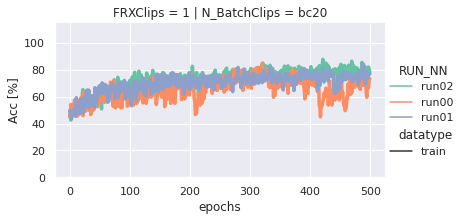

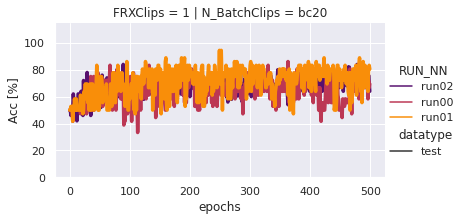

     epochs      LR N_BatchClips FRXClips datatype      Loss RUN_NN
0         0  lr0.01         bc20        1    train  0.769775  run02
1         1  lr0.01         bc20        1    train  0.822214  run02
2         2  lr0.01         bc20        1    train  0.894394  run02
3         3  lr0.01         bc20        1    train  0.985095  run02
4         4  lr0.01         bc20        1    train  1.023198  run02
..      ...     ...          ...      ...      ...       ...    ...
995     495  lr0.01         bc20        1     test  0.520682  run01
996     496  lr0.01         bc20        1     test  0.581212  run01
997     497  lr0.01         bc20        1     test  0.403849  run01
998     498  lr0.01         bc20        1     test  0.411354  run01
999     499  lr0.01         bc20        1     test  0.473285  run01

[3000 rows x 7 columns]


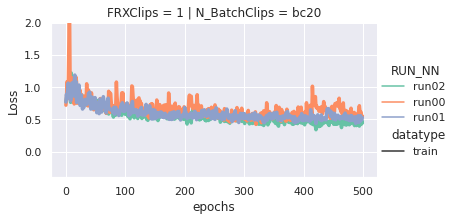

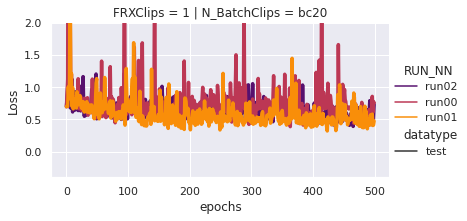

In [3]:
TYPE_str = 'ACC'    
FRAMES_PER_SEGMENT_IN_A_CLIP = 1
BatchClips=20
LR=0.01
STR_VARIABLE_NAME = 'Acc [%]'
RUN_VERSION=['run02', 'run00', 'run01']
acc0_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[0]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,LR, STR_VARIABLE_NAME, RUN_VERSION[0])
acc1_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[1]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,LR, STR_VARIABLE_NAME, RUN_VERSION[1])
acc2_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[2]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,LR, STR_VARIABLE_NAME, RUN_VERSION[2])


acc_dfall = [acc0_all_, acc1_all_,acc2_all_]
acc_all = pd.concat(acc_dfall)
print(acc_all)


sns.set(style="darkgrid")#sns.set(style="ticks")
g0=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="RUN_NN",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=acc_all.query("datatype == 'train'"))#data=acc_all)
g0.set(ylim=(0, 115))

sns.set(style="darkgrid")
g1=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="RUN_NN",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="inferno",#palette=palette,
            data=acc_all.query("datatype == 'test'"))#data=acc_all)
g1.set(ylim=(0, 115))

plt.show()


TYPE_str = 'LOS'    
BatchClips=20
STR_VARIABLE_NAME = 'Loss'
loss0_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[0]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,LR, STR_VARIABLE_NAME, RUN_VERSION[0])
loss1_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[1]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,LR, STR_VARIABLE_NAME, RUN_VERSION[1])
loss2_all_=json2DataFrame(TRAINING_CURVES_PATH,str(json_files[2]), 
                    TYPE_str, FRAMES_PER_SEGMENT_IN_A_CLIP, BatchClips,LR, STR_VARIABLE_NAME, RUN_VERSION[2])

loss_dfall = [loss0_all_, loss1_all_,loss2_all_]
loss_all = pd.concat(loss_dfall)
print(loss_all)


sns.set(style="darkgrid")#sns.set(style="ticks")
g2=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="RUN_NN",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=loss_all.query("datatype == 'train'"))#data=acc_all)
g2.set(ylim=(-0.4, 2))

sns.set(style="darkgrid")
g3=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="RUN_NN",
            col="N_BatchClips", 
            row="FRXClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="inferno",#palette=palette,
            data=loss_all.query("datatype == 'test'"))#data=acc_all)
g3.set(ylim=(-0.4, 2))

plt.show()
    

## 3. Plotting Paramters of Performance

elapsed_time_for_the_NOTEBOOK_in_secs [652.0537588596344, 590.0780346393585, 591.2955446243286]
elapsed_time_for_the_training_loop_in_secs [310.8367373943329, 302.2821228504181, 303.66452193260193]
Precision [0.6726726726726721, 0.6138716356107661, 0.7474747474747471]
F1score [0.5687500000000001, 0.61343669250646, 0.6370370370370371]


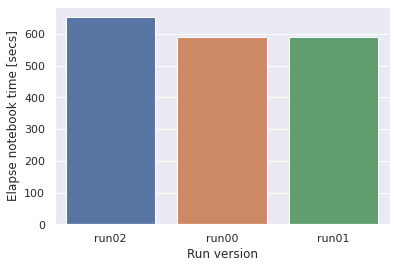

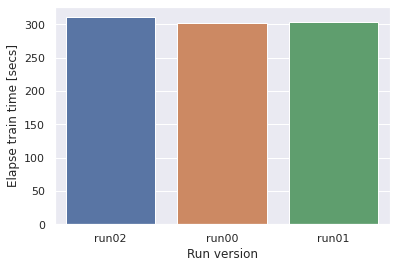

In [4]:
elapsed_time_for_the_NOTEBOOK_in_secs=[]
elapsed_time_for_the_training_loop_in_secs=[]
Precision=[]
F1score=[]

for i in range(0, len(json_files_params)):
    params=jsonPARAMS2DataFrame(TRAINING_CURVES_PATH,str(json_files_params[i]))
    elapsed_time_for_the_NOTEBOOK_in_secs.append(params[0])
    elapsed_time_for_the_training_loop_in_secs.append(params[1])
    Precision.append(params[11]['Precision']['weighted avg/Total'])
    F1score.append(params[11]['F1-score']['weighted avg/Total'])
    
print(f'elapsed_time_for_the_NOTEBOOK_in_secs {elapsed_time_for_the_NOTEBOOK_in_secs}')    
print(f'elapsed_time_for_the_training_loop_in_secs {elapsed_time_for_the_training_loop_in_secs}')
print(f'Precision {Precision}')   
print(f'F1score {F1score}')


elapsetime_notebook_df = pd.DataFrame(elapsed_time_for_the_NOTEBOOK_in_secs).reset_index(drop=True)
elapsetime_notebook_df.rename(columns={0:"Elapse notebook time [secs]"}, inplace=True)

elapsetime_train_df = pd.DataFrame(elapsed_time_for_the_training_loop_in_secs).reset_index(drop=True)
elapsetime_train_df.rename(columns={0:"Elapse train time [secs]"}, inplace=True)

run_df = pd.DataFrame(RUN_VERSION).reset_index(drop=True)
run_df.rename(columns={0:"Run version"}, inplace=True)

en_df = pd.concat([run_df, elapsetime_notebook_df ], axis=1)
ax = sns.barplot(x="Run version", y="Elapse notebook time [secs]", data=en_df)
plt.show()


et_df = pd.concat([run_df, elapsetime_train_df ], axis=1)
ay = sns.barplot(x="Run version", y="Elapse train time [secs]", data=et_df)
plt.show()



##https://seaborn.pydata.org/generated/seaborn.barplot.html